In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [174]:
data = pd.read_csv('housing.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [175]:
# cleaned data
print(data['total_bedrooms'].hasnans)
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())
data.dropna(inplace=True)
print(data['total_bedrooms'].hasnans)

True
False


In [176]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [177]:
# median house value is the target value 
# the rest are training features/set
from sklearn.model_selection import train_test_split
X = data.drop(['median_house_value'],axis=1)
y =data['median_house_value']

In [178]:
train_data = X_train.join(y_train)
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
16550,-121.23,37.82,8.0,1289.0,235.0,867.0,239.0,4.6821,INLAND,138500.0
934,-122.04,37.53,25.0,4458.0,922.0,2998.0,890.0,3.9667,NEAR BAY,218500.0
14439,-117.24,32.80,30.0,1917.0,462.0,828.0,437.0,2.4671,NEAR OCEAN,276300.0
10374,-117.66,33.63,16.0,3299.0,610.0,1967.0,604.0,5.5085,<1H OCEAN,223300.0
5994,-117.72,34.09,33.0,4979.0,934.0,2575.0,874.0,3.7958,INLAND,152500.0
...,...,...,...,...,...,...,...,...,...,...
18311,-122.12,37.42,36.0,2607.0,551.0,1165.0,523.0,5.1524,NEAR BAY,373100.0
6181,-117.92,34.08,35.0,1897.0,311.0,965.0,323.0,5.7039,<1H OCEAN,199400.0
14363,-117.23,32.73,35.0,2914.0,683.0,1562.0,638.0,2.5259,NEAR OCEAN,240200.0
17849,-121.87,37.42,25.0,4430.0,729.0,2685.0,721.0,5.6965,<1H OCEAN,261100.0


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

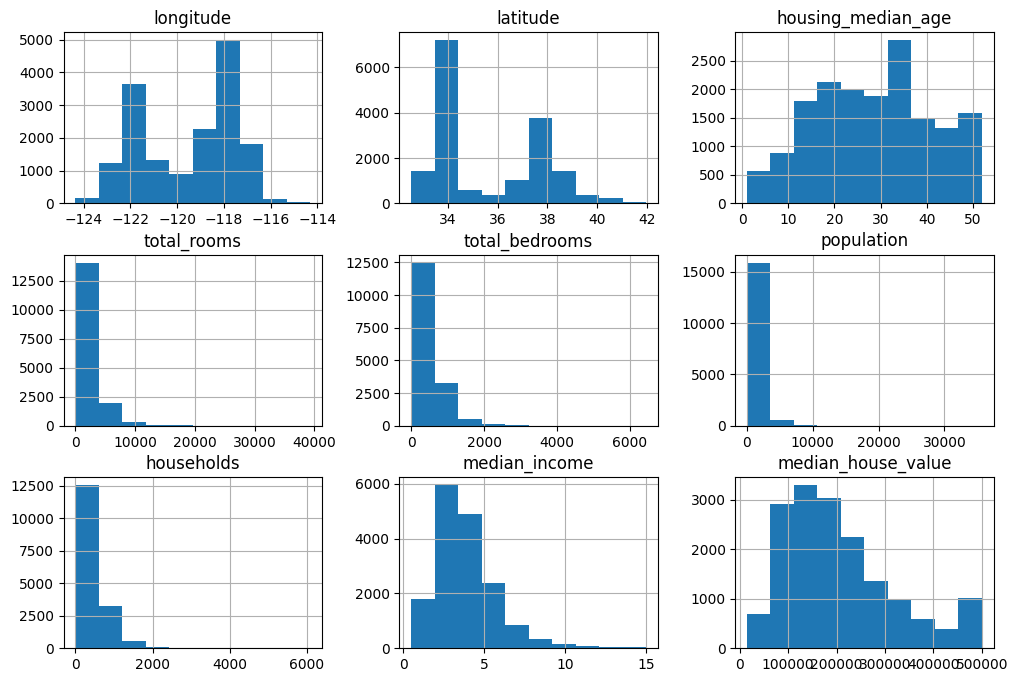

In [179]:
# data visualizatoin
train_data.hist(figsize=(12,8))

<Axes: >

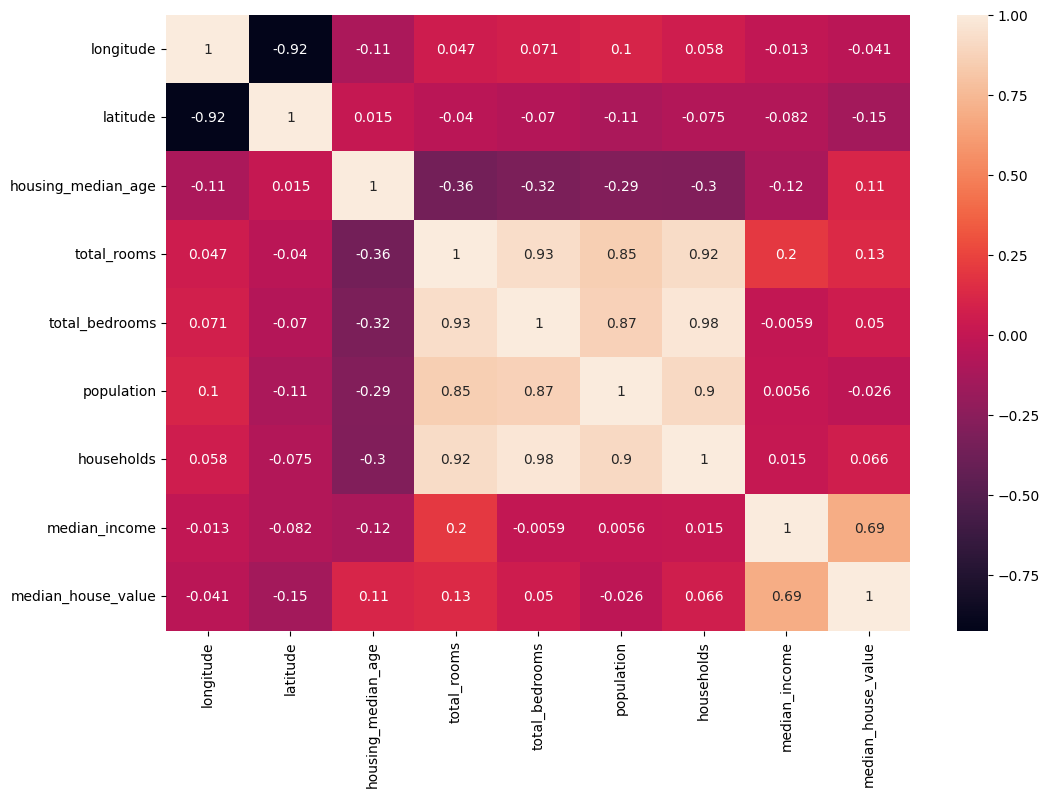

In [180]:
# more data visualization using seabonr
plt.figure(figsize=(12,8))
sns.heatmap(train_data.loc[:,train_data.columns != "ocean_proximity"].corr(),annot=True)

In [181]:
# adjustings the histograms to try to achieve more of a bell curve to find a correlation
# and to see if feature engineering is necessary
train_data['total_rooms'] = np.log(train_data['total_rooms']+1)
train_data['total_bedrooms'] = np.log(train_data['total_bedrooms']+1)
train_data['population'] = np.log(train_data['population']+1)
train_data['households'] = np.log(train_data['households']+1)


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

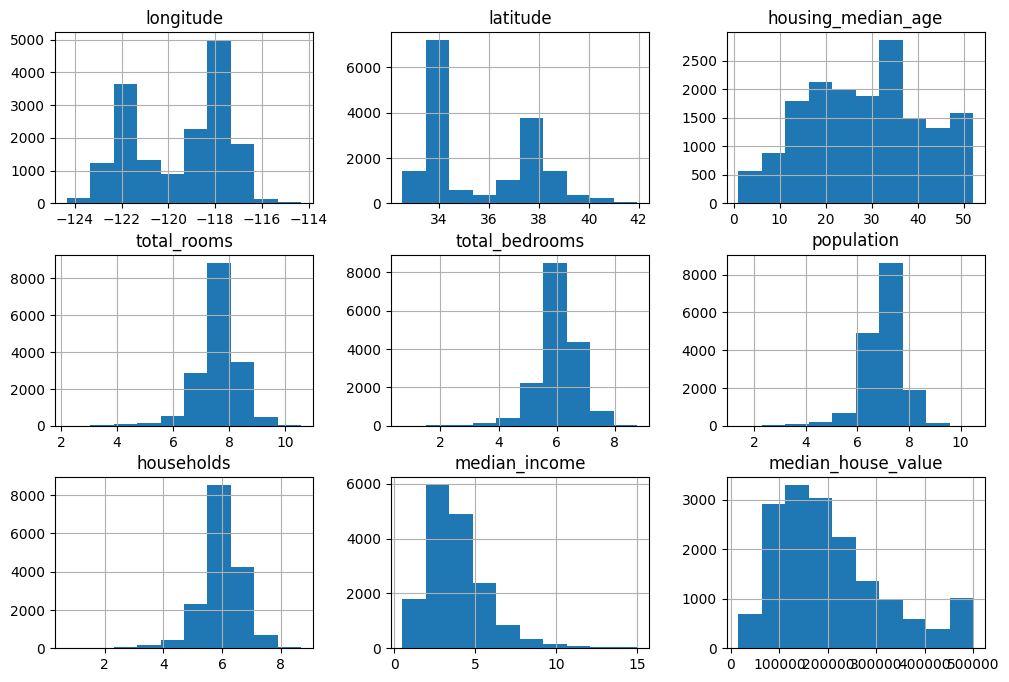

In [182]:
# after adjusting data skewed
# bell curved is achieved in four features
train_data.hist(figsize=(12,8))

<Axes: >

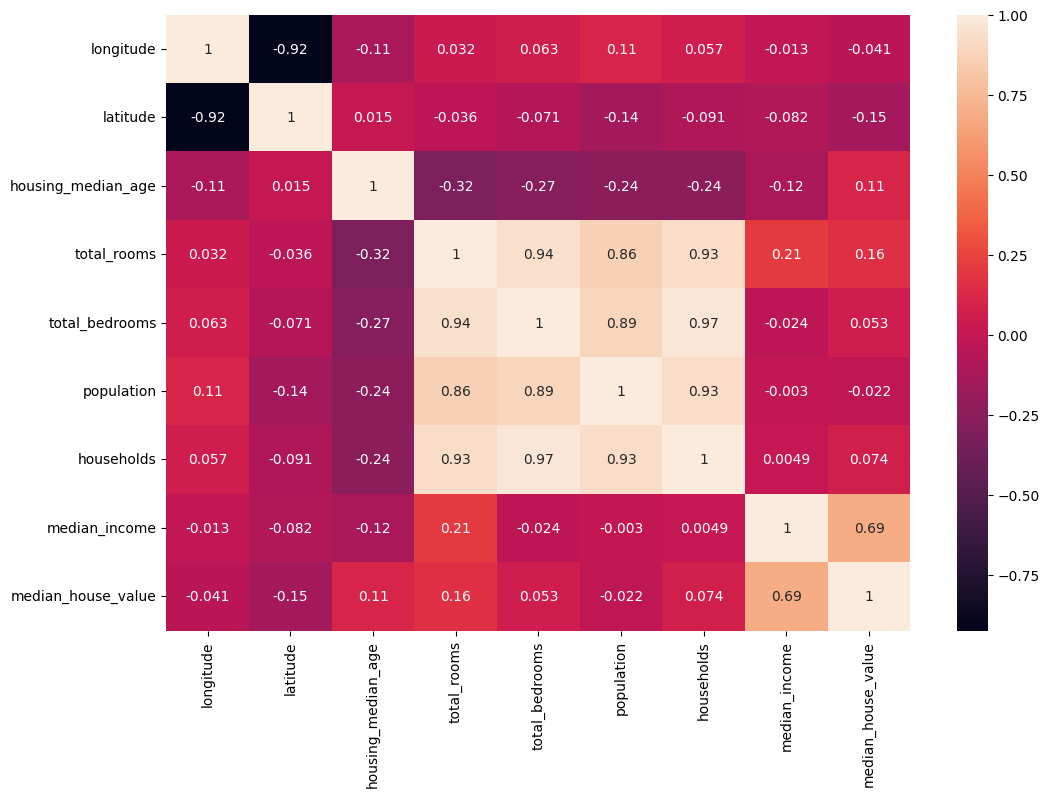

In [183]:
# heatmap visualization after adjusting data
plt.figure(figsize=(12,8))
sns.heatmap(train_data.loc[:,train_data.columns != "ocean_proximity"].corr(),annot=True)

In [184]:
# getting value counts to object data
train_data.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     7280
INLAND        5264
NEAR OCEAN    2137
NEAR BAY      1828
ISLAND           3
Name: count, dtype: int64

In [185]:
#getting binary values for object data to normalize later
pd.get_dummies(train_data.ocean_proximity)

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
16550,False,True,False,False,False
934,False,False,False,True,False
14439,False,False,False,False,True
10374,True,False,False,False,False
5994,False,True,False,False,False
...,...,...,...,...,...
18311,False,False,False,True,False
6181,True,False,False,False,False
14363,False,False,False,False,True
17849,True,False,False,False,False


In [186]:
# joining converted data to the dataset to visulize
train_data= train_data.join(pd.get_dummies(train_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
16550,-121.23,37.82,8.0,7.162397,5.463832,6.766192,5.480639,4.6821,138500.0,False,True,False,False,False
934,-122.04,37.53,25.0,8.402680,6.827629,8.006034,6.792344,3.9667,218500.0,False,False,False,True,False
14439,-117.24,32.80,30.0,7.559038,6.137727,6.720220,6.082219,2.4671,276300.0,False,False,False,False,True
10374,-117.66,33.63,16.0,8.101678,6.415097,7.584773,6.405228,5.5085,223300.0,True,False,False,False,False
5994,-117.72,34.09,33.0,8.513185,6.840547,7.853993,6.774224,3.7958,152500.0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,-122.12,37.42,36.0,7.866339,6.313548,7.061334,6.261492,5.1524,373100.0,False,False,False,True,False
6181,-117.92,34.08,35.0,7.548556,5.743003,6.873164,5.780744,5.7039,199400.0,True,False,False,False,False
14363,-117.23,32.73,35.0,7.977625,6.527958,7.354362,6.459904,2.5259,240200.0,False,False,False,False,True
17849,-121.87,37.42,25.0,8.396381,6.593045,7.895808,6.582025,5.6965,261100.0,True,False,False,False,False


<Axes: >

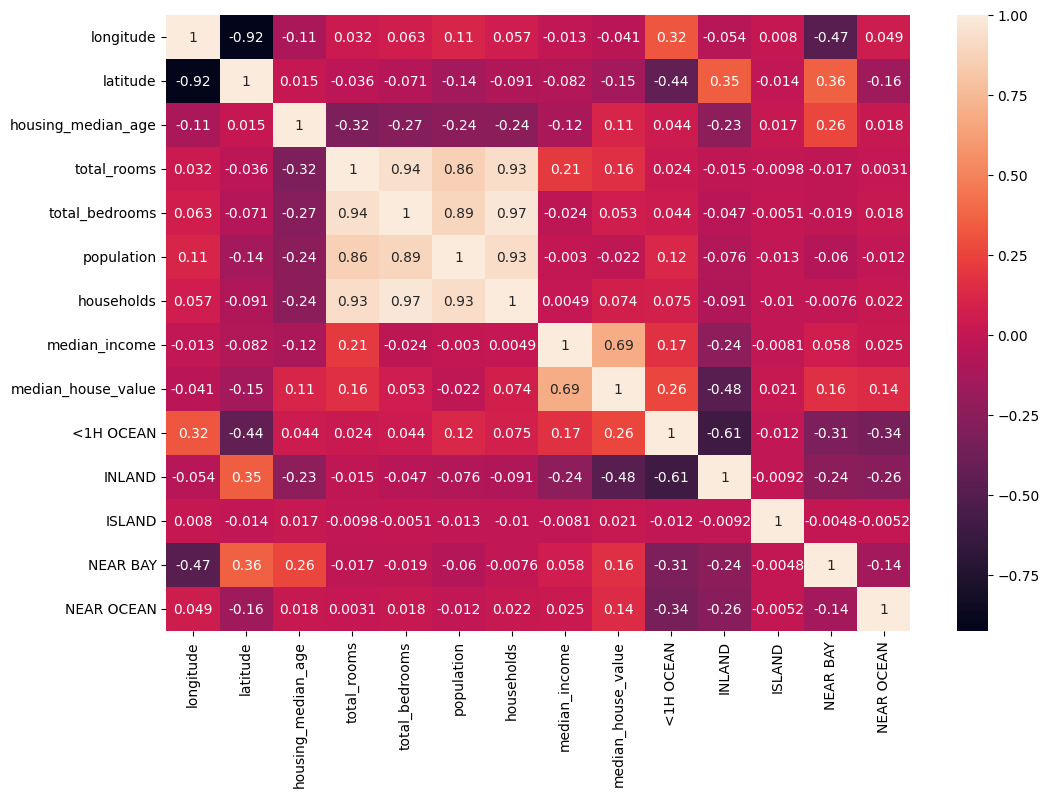

In [187]:
# data visualized to heapmap
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(),annot=True)

<Axes: xlabel='latitude', ylabel='longitude'>

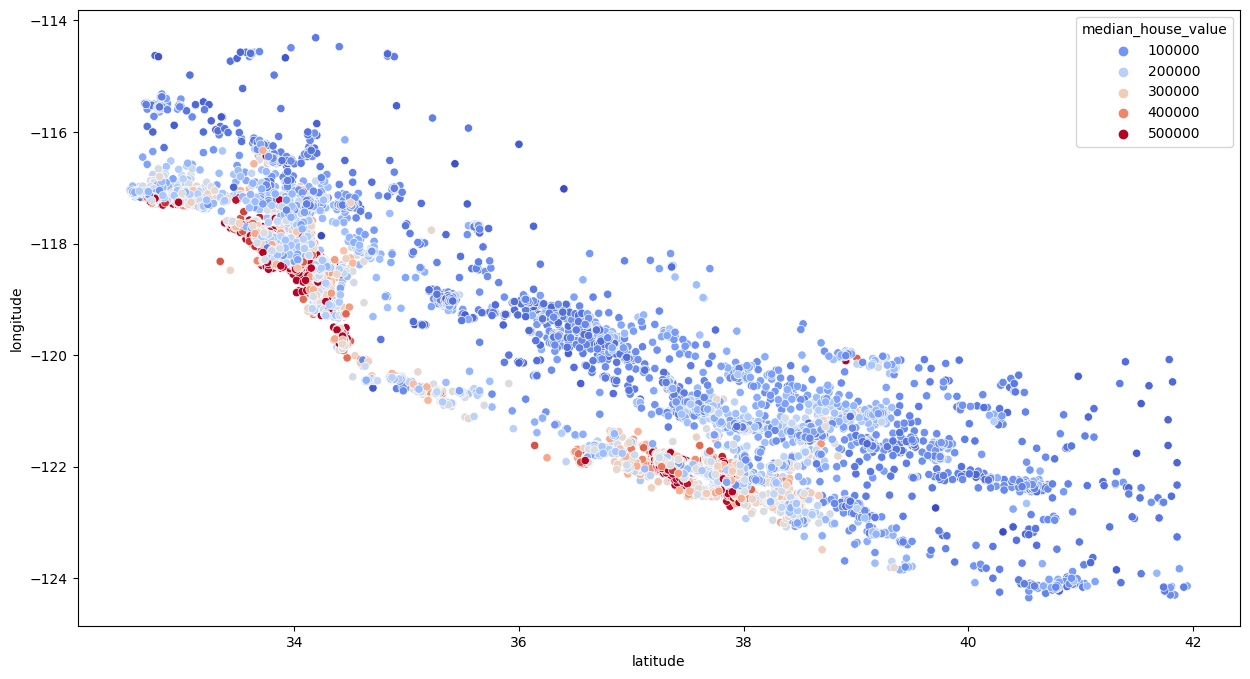

In [188]:
# scatter plot to highlight what data seems to be 
# more affected by location to find further visualization 
plt.figure(figsize=(15,8))
sns.scatterplot(x='latitude',y='longitude',data=train_data, hue='median_house_value', palette='coolwarm')

<Axes: >

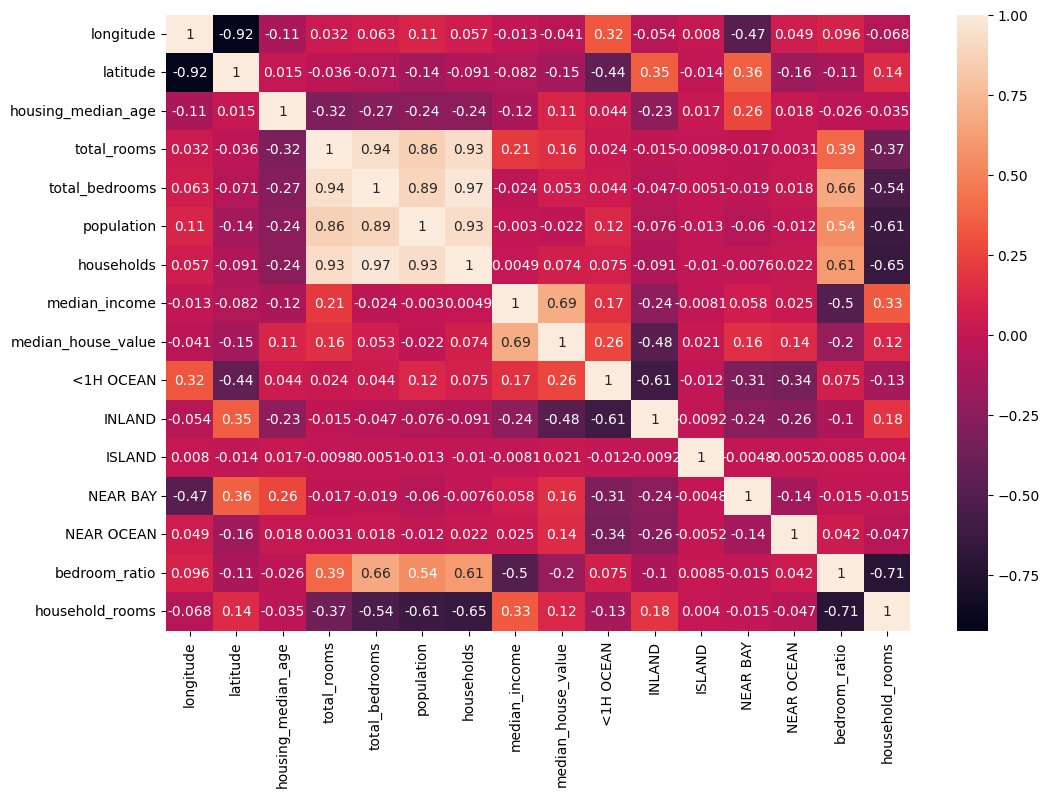

In [189]:

# engineering more features to look at the ratios for bedrooms to total rooms and 
# total rooms to households to see how they correlate to each other
train_data['bedroom_ratio'] = train_data['total_bedrooms']/train_data['total_rooms']
train_data['household_rooms'] =train_data['total_rooms'] / train_data['households']
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(),annot=True)

In [190]:
# linear regression testing 
# Note: not the best type of regressison for this data set
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=.2)
scalar= StandardScaler()
x_train,y_train = train_data.drop(['median_house_value'],axis=1), train_data['median_house_value']
x_test_s = scalar.fit_transform(X_test)
x_train_s=scalar.fit_transform(X_train)
reg = LinearRegression()
reg.fit(x_train_s,y_train)

ValueError: could not convert string to float: '<1H OCEAN'

In [191]:
test_data = x_test_s.join(y_test)

test_data['total_rooms'] = np.log(test_data['total_rooms']+1)
test_data['total_bedrooms'] = np.log(test_data['total_bedrooms']+1)
test_data['population'] = np.log(test_data['population']+1)
test_data['households'] = np.log(test_data['households']+1)

test_data= test_data.join(pd.get_dummies(test_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

test_data['bedroom_ratio'] = test_data['total_bedrooms']/test_data['total_rooms']
test_data['household_rooms'] =test_data['total_rooms'] / test_data['households']

x_train_s,y_train = train_data.drop(['median_house_value'],axis=1), train_data['median_house_value']


AttributeError: 'DataFrame' object has no attribute 'ocean_proximity'

In [ ]:
x_test_s,y_test = test_data.drop(['median_house_value'],axis=1), test_data['median_house_value']


In [ ]:
# test results for linear regression 
print("train: ",reg.score(x_train_s,y_train))
print("train: ",reg.score(x_test_s,y_test))


NameError: name 'reg' is not defined

In [ ]:
# random forest regressor to examine
# differences between linear and random forest regression
from sklearn.ensemble import RandomForestRegressor

scaler =StandardScaler()
X_test_s = scaler.fit_transform(X_test)
X_train_s =scaler.fit_transform(X_train)
forest = RandomForestRegressor()

forest.fit(X_train_s,y_train)

RandomForestRegressor()

In [ ]:
# large difference between linear regression and random forest

print("train: ", forest.score(X_train_s,y_train))
print("test: ",forest.score(X_test_s,y_test))

train:  0.9742285068294759
test:  0.7398094137457685


In [ ]:
from sklearn.model_selection import GridSearchCV
forest = RandomForestRegressor()
param_grid = {
    "n_estimators": [400,500,600],
    "max_features": [8,10,20],
}
g_search = GridSearchCV(forest,param_grid=param_grid,cv=5,scoring="neg_mean_squared_error", return_train_score=True)
g_search.fit(X_train_s,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 10, 20],
                         'n_estimators': [400, 500, 600]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
g_search.best_estimator_

RandomForestRegressor(max_features=10, n_estimators=500)

In [ ]:
best_forest = g_search.best_estimator_

In [ ]:
print("train: ", best_forest.score(X_train_s,y_train))
print("test: ",best_forest.score(X_test_s,y_test))

train:  0.9756861341473076
test:  0.7544436675050356
